# RooFit Toy Fitter

### Omar Moreno (Santa Cruz Institute for Particle Physics, University of California, Santa Cruz)

In [1]:
# This allows matplotlib plots to be shown inline
%matplotlib inline

import ROOT as r
import rootnotes
import numpy as np
import matplotlib.pyplot as plt
from rootpy.io import root_open
import rootpy.plotting.root2matplotlib as rplt

canvas = rootnotes.default_canvas()

plt.style.use('bmh')

/home/omoreno/packages/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


# Composite Model

The composite model used to fit our distribution has the following form:

$M(x) = N_{S}S(x) + N_BB(x)$

Here, $S(x)$ is a gaussian pdf with a mean set to the center of the fit window and the width set to some arbritary resolution.  The background, $B(x)$ will be described using a 1st order polynomial.

In [2]:
x = r.RooRealVar("x", "x", 0, 10)

t0 = r.RooRealVar("t0", "t0", -0.5, -1, 1.)
#t1 = r.RooRealVar("t1", "t1", -0.2, 0., 1.)
arg_list = r.RooArgList()
arg_list.add(t0)
#arg_list.add(t1)

bkg_model = r.RooChebychev("bkg_model", "bkg_model", x,  arg_list)

mean = r.RooRealVar("mean", "mean", 5)
sigma = r.RooRealVar("sigma", "sigma", 1)
sig_model = r.RooGaussian("signal", "signal", x, mean, sigma)

# Number of events
nsig = r.RooRealVar("nsig","signal fraction", 0, -1100, 1100)
nbkg = r.RooRealVar("nbkg","background fraction", 10000., 0.,100000000.) 

comp_model = r.RooAddPdf("comp_model", "comp_model", r.RooArgList(sig_model, bkg_model), r.RooArgList(nsig, nbkg))

# Fitting the full range using the composite model

To begin, generate 1000 toys by sampling the background PDF only and then fit the full range of each of the distributions using the composite model.

In [3]:
s = []
s_error = []

for trials in range (0, 1000) : 
    
    arg_set = r.RooArgSet(x)
    x.setBins(400)
    hist = bkg_model.generateBinned(arg_set, 50000, r.RooFit.Extended(r.kTRUE))
    
    nll = comp_model.createNLL(hist, r.RooFit.Extended(r.kTRUE))
    
    m = r.RooMinuit(nll)
    m.setVerbose(r.kTRUE)
    
    m.migrad()
    
    m.improve()
    
    m.hesse()
    
    m.minos()

    result = m.save()
    
    params = comp_model.getVariables()
    s.append(params.find("nsig").getVal())
    s_error.append(params.find("nsig").getError())
    
    # Reset all of the parameters
    initial_params = result.floatParsInit()
    
    nbkg.setVal(initial_params[initial_params.index(nbkg.GetName())].getVal())
    nbkg.setError(initial_params[initial_params.index(nbkg.GetName())].getError())
    nsig.setVal(initial_params[initial_params.index(nsig.GetName())].getVal())
    nsig.setError(initial_params[initial_params.index(nsig.GetName())].getError())
    
    t0.setVal(initial_params[initial_params.index(t0.GetName())].getVal())
    t0.setError(initial_params[initial_params.index(t0.GetName())].getError())

Plot the signal yield, error and pulls resulting from the fits done above.

Signal mean: -0.833111838668
Signal error: 164.405244802
Error mean: 164.472770505
Error sigma: 0.606440002121
Pull mean: -0.0075710121026
Pull sigma: 0.999802535012


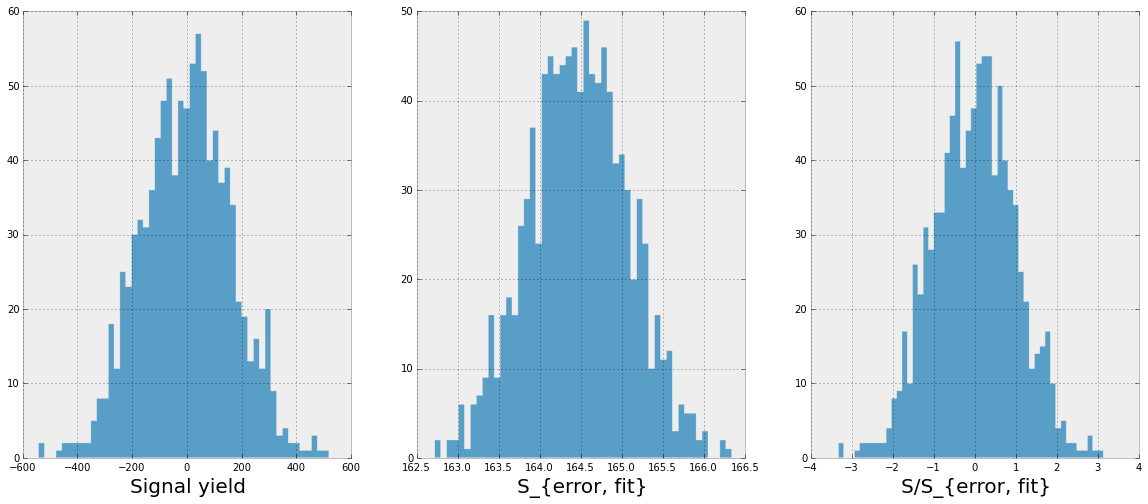

In [13]:
s_array = np.array(s)
print "Signal mean: " + str(np.mean(s_array))
print "Signal error: " + str(np.std(s_array))

s_error_array = np.array(s_error)
print "Error mean: " + str(np.mean(s_error_array))
print "Error sigma: " + str(np.std(s_error_array))

s_pull = np.divide(s_array, s_error_array)
print "Pull mean: " + str(np.mean(s_pull))
print "Pull sigma: " + str(np.std(s_pull))

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(20, 8))

ax0.hist(s_array, bins=50, histtype="stepfilled", alpha=0.8)
ax0.set_xlabel("Signal yield", fontsize=20)
ax1.hist(s_error_array, bins=50, histtype="stepfilled", alpha=0.8)
ax1.set_xlabel("S_{error, fit}", fontsize=20)
ax2.hist(s_pull, bins=50, histtype="stepfilled", alpha=0.8)
ax2.set_xlabel("S/S_{error, fit}", fontsize=20);

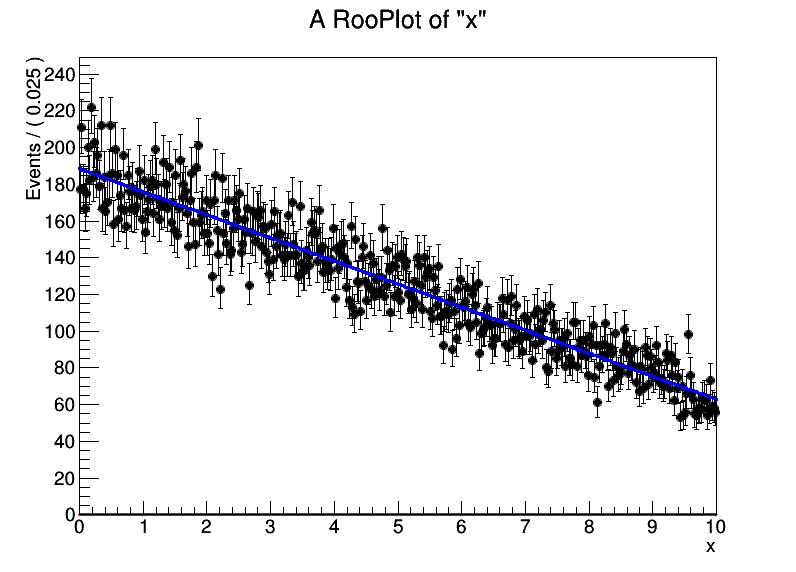

In [14]:
frame = x.frame()
hist.plotOn(frame)
comp_model.plotOn(frame)
comp_model.plotOn(frame, 
                 r.RooFit.Components("signal"), 
                 r.RooFit.LineStyle(r.RooFit.kDashed),
                 r.RooFit.LineColor(r.RooFit.kRed))

frame.Draw()
canvas

# Fitting sub-ranges of the distribution using the composite model

Instead of fitting the full range, the composite model is used to fit windows of size 4.  The mean of the signal is set to the center of the window.  The window is shifted by 1 until the full distribution is fit.

In [15]:
s_window = []
s_window_error = []

arg_set = r.RooArgSet(x)
x.setBins(400)

x.setRange("test range", 3, 7)

window_start = 0
window_size = 4
step = 1

while window_start + window_size <= 10 : 
    
    window_center = window_start + window_size/2
    mean.setVal(window_center)
    x.setRange("window center = " + str(window_center), window_start, window_start + window_size)

    s = []
    s_error = []
    
    for trials in range (0, 1000) :

        hist = bkg_model.generateBinned(arg_set, 50000, r.RooFit.Extended(r.kTRUE))
        nll = comp_model.createNLL(hist, r.RooFit.Extended(r.kTRUE), r.RooFit.Range("window center = " + str(window_center)), 
                                   r.RooFit.SumCoefRange("window center = " + str(window_center)))

        m = r.RooMinuit(nll)
        #m.setVerbose(r.kTRUE)
    
        m.migrad()
    
        m.improve()
    
        m.hesse()
    
        m.minos()
    
        result = m.save()
    
        params = comp_model.getVariables()
        s.append(params.find("nsig").getVal())
        s_error.append(params.find("nsig").getError())
    
    # Reset all of the parameters
        initial_params = result.floatParsInit()
    
        nbkg.setVal(initial_params[initial_params.index(nbkg.GetName())].getVal())
        nbkg.setError(initial_params[initial_params.index(nbkg.GetName())].getError())
        nsig.setVal(initial_params[initial_params.index(nsig.GetName())].getVal())
        nsig.setError(initial_params[initial_params.index(nsig.GetName())].getError())
    
        t0.setVal(initial_params[initial_params.index(t0.GetName())].getVal())
        t0.setError(initial_params[initial_params.index(t0.GetName())].getError())
    
    window_start += step
    
    s_window.append(s)
    s_window_error.append(s_error)

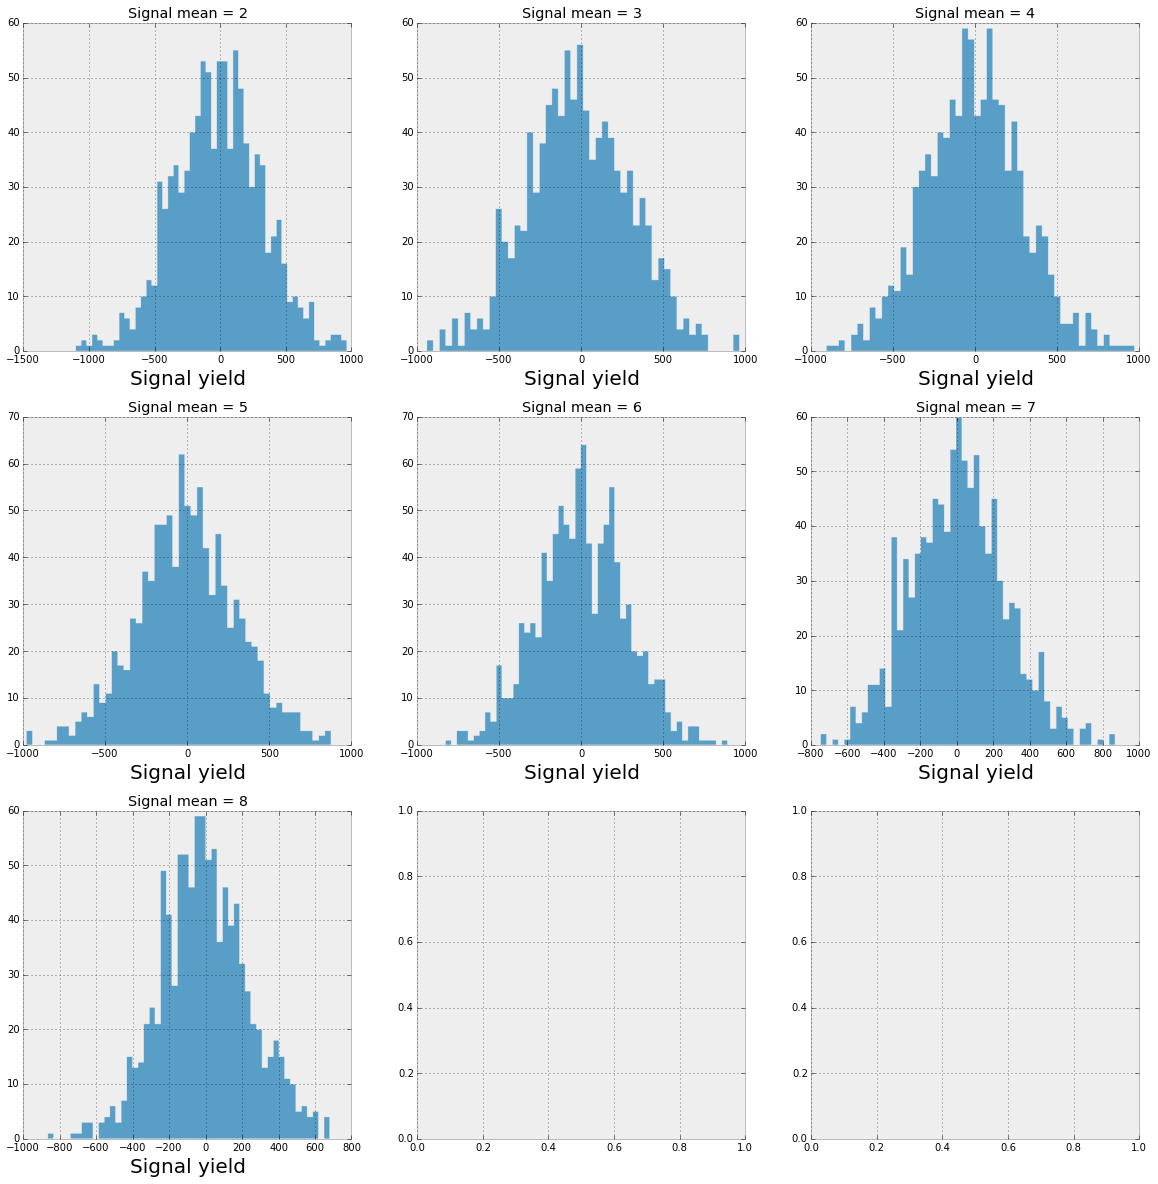

In [17]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20, 20))
ax = axes.flatten()

for index in range(0, len(s_window)) : 
    ax[index].set_title("Signal mean = " + str(index + 2))
    ax[index].hist(s_window[index], bins=50, histtype="stepfilled", alpha=0.8)
    ax[index].set_xlabel("Signal yield", fontsize=20)

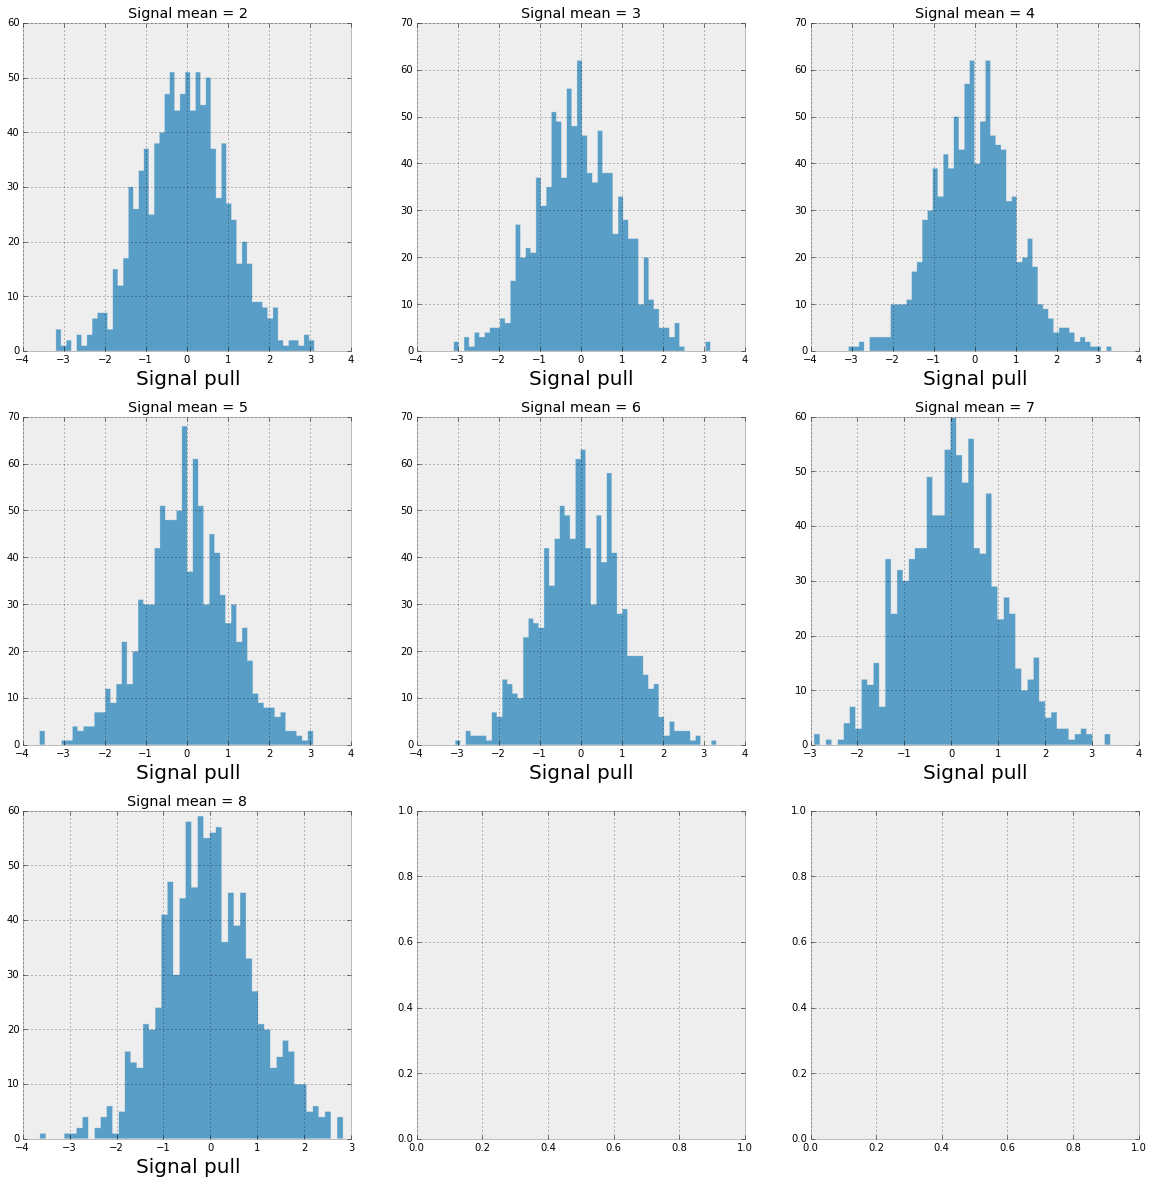

In [20]:
s_pull_windows = []
signal_mean = []

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20, 20))
ax = axes.flatten()

for index in range(0, len(s_window)) : 
    
    s_pull_windows.append(np.divide(np.array(s_window[index]), np.array(s_window_error[index])))
    signal_mean.append(index + 2)
    ax[index].set_title("Signal mean = " + str(signal_mean[index]))
    ax[index].hist(s_pull_windows[index], bins=50, histtype="stepfilled", alpha=0.8)
    ax[index].set_xlabel("Signal pull", fontsize=20)

Plot the signal yield mean and the pulls as a function of signal mean.  For the signal yield, also include the 90% confidence interval.

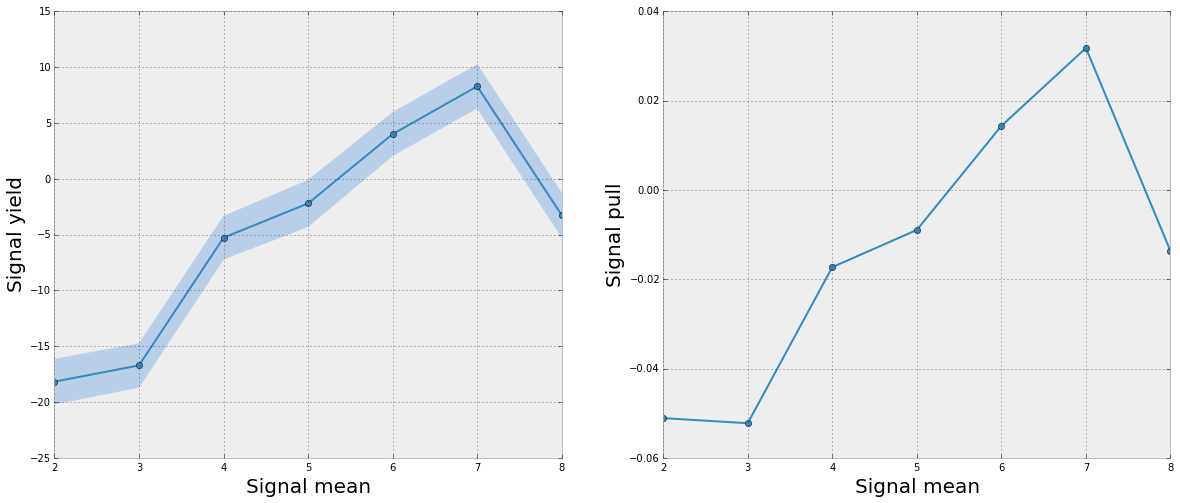

In [34]:
signal_yield_mean = []
s_pull_mean = []
signal_error = []

for index in range(0, len(s_window)) :
    signal_yield_mean.append(np.mean(np.array(s_window[index])))
    s_pull_mean.append(np.mean(np.array(s_pull_windows[index])))
    signal_error.append(np.std(np.array(s_pull_windows[index])))
    
signal_yield_array = np.array(signal_yield_mean)
signal_error_array = np.array(signal_error)
    
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 8))
ax0.plot(signal_mean, signal_yield_mean, 'o-')
ax0.set_xlabel("Signal mean", fontsize=20)
ax0.set_ylabel("Signal yield", fontsize=20)
ax0.fill_between(signal_mean, signal_yield_array + 1.96*signal_error_array, signal_yield_array - 1.96*signal_error_array, color='#b9cfe7')
ax1.plot(signal_mean, s_pull_mean, 'o-')
ax1.set_xlabel("Signal mean", fontsize=20)
ax1.set_ylabel("Signal pull", fontsize=20);


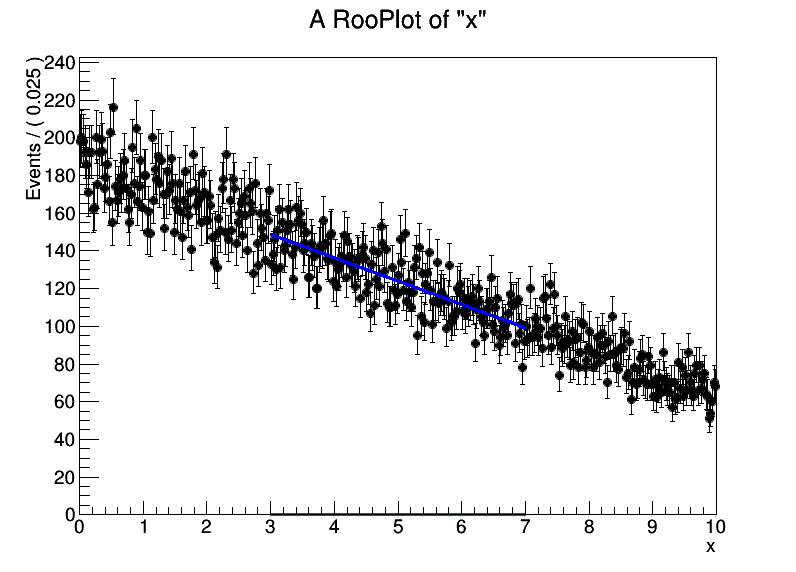

In [28]:
frame = x.frame()
hist.plotOn(frame)
comp_model.plotOn(frame, r.RooFit.NormRange("test range"), r.RooFit.Range("test range"))
comp_model.plotOn(frame, 
                  r.RooFit.NormRange("test range"), r.RooFit.Range("test range"), 
                 r.RooFit.Components("signal"), 
                 r.RooFit.LineStyle(r.RooFit.kDashed),
                 r.RooFit.LineColor(r.RooFit.kRed))

frame.Draw()
canvas